In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import tqdm

import torch
import torch_geometric.data

from sklearn.metrics.pairwise import cosine_similarity
from similarity import calculate_tanimoto_similarity, get_zeolite_similarity


In [2]:
with open(f'ZeoSynGen_dataset.pkl', 'rb') as f: # load scaler
    dataset = pickle.load(f)

In [3]:
def plot_gel_conds(x_syn_ratio, label=None):
    '''
    Args:
        x_syn_ratio: (pd.DataFrame) with columns of synthesis conditions
        label: (str) label for the plot
    '''
    xlims = {'Si/Al': [-5,410],
                'Al/P': [-0.1,1.8],
                'Si/Ge': [-5,100],
                'Si/B': [-10,260],
                'Na/T': [-0.2,2],
                'K/T': [-0.5,5.4],
                'OH/T': [-0.1,2.5],
                'F/T': [-0.05,1.3],
                'H2O/T': [-10,210],
                'sda1/T': [-0.3,7],
                'cryst_temp': [0,250],
                'cryst_time': [0,1000],
                }
    fontsize = 15
    fig = plt.figure(figsize=(6/3*len(x_syn_ratio.columns),3), dpi = 100)
    col_idx = 1
    for col_name in x_syn_ratio.columns:
        ax = fig.add_subplot(1, len(x_syn_ratio.columns), col_idx)
        sns.histplot(x_syn_ratio[col_name], label=label, bins=30, binrange=xlims[col_name])
        
        ax.yaxis.set_tick_params(labelleft=False)
        plt.xlim(*xlims[col_name])
        plt.xlabel(col_name, fontsize=fontsize)
        if col_idx > 1:
            plt.ylabel('')
        else:
            plt.ylabel('Density', fontsize=fontsize)
        col_idx += 1
    plt.legend()
    plt.show()

In [4]:
# Get all datapoints from dataset object
all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=False, return_dataframe=True)

# Create DataFrame with all datapoints
df = all_datapoints[1]
df['zeo'] = all_datapoints[3]
df['osda'] = all_datapoints[13]
df

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,150.000000,504.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,175.000000,168.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,150.000000,144.000000,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,115.720856,660.165100,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,125.000000,72.000000,BPH,CC[N+](CC)(CC)CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,135.000000,558.916321,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,160.000000,240.032150,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,53.891212,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,193.911392,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3


In [ ]:
osda_sims, syn_sims = [], []
zeos, osda_refs, osda_srcs = [], [], []
for zeo, c in df['zeo'].value_counts().items():
    if zeo != 'Dense/Amorphous':
        print(zeo)
        df_zeo = df[df['zeo']==zeo]
        df_zeo = df_zeo.drop(columns=['zeo'])

        unique_osdas = list(df_zeo['osda'].value_counts().keys())
        print('n_syn:', c)
        print('n_osda:', len(unique_osdas))
        
        # osda_sims, syn_sims = [], []

        for ref_idx in range(len(unique_osdas)):
            osda_ref = unique_osdas[ref_idx] # Reference OSDA
            df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

            for src_idx in range(ref_idx): # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
                osda_src = unique_osdas[src_idx] # Source OSDA
                df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])

                # 1) OSDA SIMILARITY
                if (osda_ref == 'OSDA-free') or (osda_src == 'OSDA-free'):
                    osda_sim = 0.
                else:
                    osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

                # 2) SYNTHESIS SIMILARITY
                # 2A) Mean cosine similarity of all pairs of synthesis conditions
                syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                # 2B) Cosine similarity of mean synthesis conditions
                # syn_sim = cosine_similarity(df_zeo_osda.mean().values.reshape(1, -1), df_zeo_osda_ref.mean().values.reshape(1, -1))[0][0]

                osda_sims.append(osda_sim), syn_sims.append(syn_sim)
                zeos.append(zeo), osda_refs.append(osda_ref), osda_srcs.append(osda_src)
                
                # plot_gel_conds(df_zeo_osda, label='Current')
                # plot_gel_conds(df_zeo_osda_ref, label='Most \n freq. OSDA')
                # print()

        # # Plot OSDA vs synthesis similarity for specific zeolite
        # plt.figure(figsize=(5,5),dpi=100)
        # plt.scatter(osda_sims, syn_sims, alpha=0.1)
        # plt.xlabel('OSDA similarity')
        # plt.ylabel('Synthesis similarity')
        # plt.show()

In [ ]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.hexbin(osda_sims, syn_sims, gridsize=30, mincnt=0, bins='log', cmap='inferno', facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('OSDA similarity', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
cb = plt.colorbar()
cb.set_label('Number of OSDA pairs', fontsize=15)
plt.xlim(-0.00,1.015)
plt.ylim(-0.02,1.015)
plt.show()

In [ ]:
len(osda_sims)

In [ ]:
high_sim_sys = pd.DataFrame({'zeo': zeos, 'osda_ref': osda_refs, 'osda_src': osda_srcs, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
high_sim_sys

In [13]:
unique_zeo_osda = list(df[['zeo', 'osda']].value_counts().keys())

zeo_sims, osda_sims, syn_sims = [], [], []
zeo_refs, osda_refs, zeo_srcs, osda_srcs = [], [], [], []

for ref_idx in tqdm.tqdm(range(len(unique_zeo_osda))):

    zeo_ref, osda_ref = unique_zeo_osda[ref_idx] # Reference zeo-OSDA

    if (zeo_ref != 'Dense/Amorphous') and (osda_ref != 'OSDA-free'):
        df_zeo_osda_ref = df[(df['zeo']==zeo_ref) & (df['osda']==osda_ref)].drop(columns=['zeo', 'osda'])

        for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
            zeo_src, osda_src = unique_zeo_osda[src_idx] # Source zeo-OSDA

            if (zeo_src != 'Dense/Amorphous') and (osda_src != 'OSDA-free'):
                df_zeo_osda_src = df[(df['zeo']==zeo_src) & (df['osda']==osda_src)].drop(columns=['zeo', 'osda'])

                # 1) ZEOLITE SIMILARITY
                zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref)

                # 2) OSDA SIMILARITY
                osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

                # 3) SYNTHESIS SIMILARITY
                syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                zeo_sims.append(zeo_sim), osda_sims.append(osda_sim), syn_sims.append(syn_sim)
                zeo_refs.append(zeo_ref), osda_refs.append(osda_ref), zeo_srcs.append(zeo_src), osda_srcs.append(osda_src)

100%|██████████| 2574/2574 [1:40:21<00:00,  2.34s/it]


In [14]:
df_zeo_osda_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'osda_ref': osda_refs, 'zeo_src': zeo_srcs, 'osda_src': osda_srcs, 'zeo_sim': zeo_sims, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
# df_zeo_osda_sim.to_csv('zeo_osda_sim.csv')

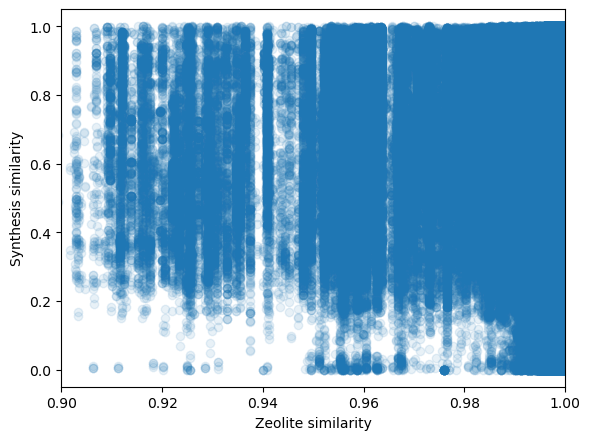

In [43]:
# df_zeo_osda_sim['zeo_sim'].hist(bins=100)
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 1000
plt.figure(figsize=(6.5,5),dpi=100)
plt.scatter(df_zeo_osda_sim['zeo_sim'], df_zeo_osda_sim['syn_sim'], alpha=0.1)
# plt.hexbin(df_zeo_osda_sim['zeo_sim'], df_zeo_osda_sim['syn_sim'], gridsize=30, bins='log', cmap='inferno')
# ax = plt.gca()
# ax.set_facecolor('black')
plt.xlabel('Zeolite similarity')
plt.ylabel('Synthesis similarity')
plt.xlim(0.9,1.0)
plt.show()